# Breast Cancer Detection from Ultrasound Images using CNNs

❓ **About the problem** <br>
❤ Breast cancer is the most diagnosed cancer among women worldwide, accounting for 1 in 4 cancer cases.<br>
❤ Breast cancer cells usually form a tumour that can often be seen on an x-ray or felt as a lump.

<img src = "https://drive.google.com/uc?id=1vLXFXuDyLBbv-QFSwsKori2zbOsIKLbX">

📔**Introduction** <br>

The goal of **semantic image segmentation** is to label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as *dense prediction*.
The **output** itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class.<br>

🗒 About the datset

The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

↪ Dataset Link : [Breast Ultrasound Image Dataset](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset)

**Step 1: Import Libraries**

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, schedules, Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.models import Model, load_model
from tensorflow.python.keras import losses

In [2]:
from __future__ import print_function

import os, glob
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, Add, MaxPooling2D, Activation, Dense, Reshape, GlobalAveragePooling2D, Multiply, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from keras.callbacks import ModelCheckpoint
from keras import backend as K
#from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#from data import load_train_data, load_test_data
from sklearn.model_selection import train_test_split
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

**Step 2: Load Dataset**

In [3]:
image_height = 256
image_width = 256
dpath = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/"
classes = ['benign', 'malignant', 'normal']

In [4]:
data = {'image' : [],
        'mask' : []}

**Step 3: Data Preprocessing**

In [5]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+class_name)
    image_names = []
    mask_names = []
    names_truncated = []
    
    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])
    
    names_truncated = list(set(names_truncated))
    
    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')
    
    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)
        
        
    return data_obj

In [6]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
#         img = plt.imread(dpath+'/'+dclass+'/'+ image_names[index])
#         mask = plt.imread(dpath+'/'+dclass+'/'+ mask_names[index])

#         img = cv2.resize(img, (img_width, img_height)) 
#         mask = cv2.resize(mask, (img_width, img_height))
        
#         mask = np.expand_dims(mask, -1)

        image_path = dpath+'/'+dclass+'/'+ image_names[index]
        mask_path = dpath+'/'+dclass+'/'+ mask_names[index]
        
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = np.round(cv2.resize(x, (image_height, image_width)))
        x.dtype = np.uint8
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [7]:
data = load_data(dpath, data, classes[0]) 
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1]) 
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


**Step 5: Visualization**

In [8]:
def visualize_example(data, index = None):
    if index is None:
        index = random.randint(0, len(data['image']))
    X = data['image']
    y = data['mask']
    has_mask = y[index].max() > 0
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[index])
    if has_mask:
        ax[0].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Mask')

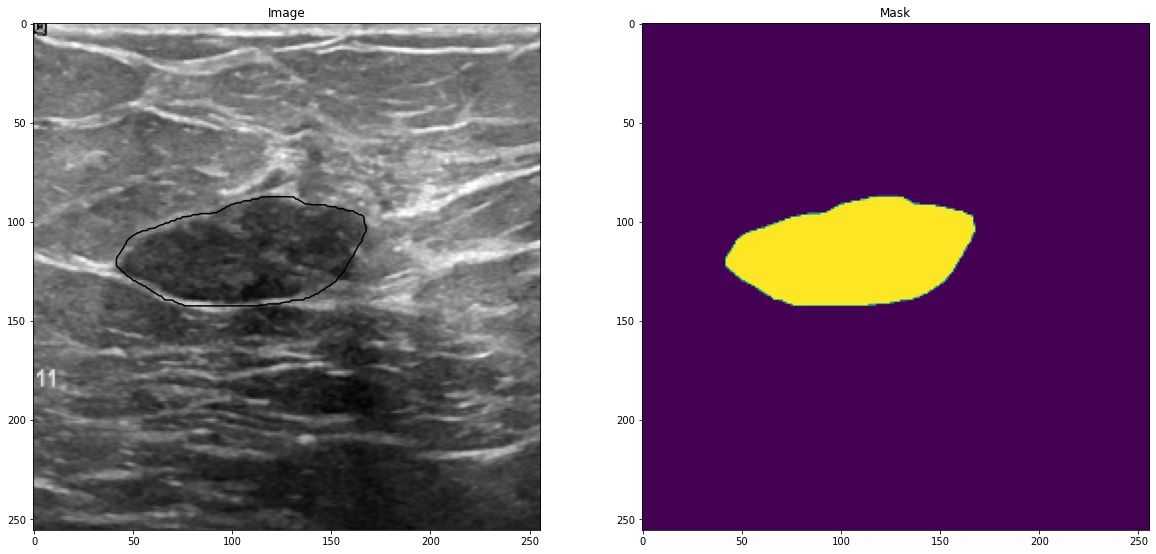

In [9]:
visualize_example(data)

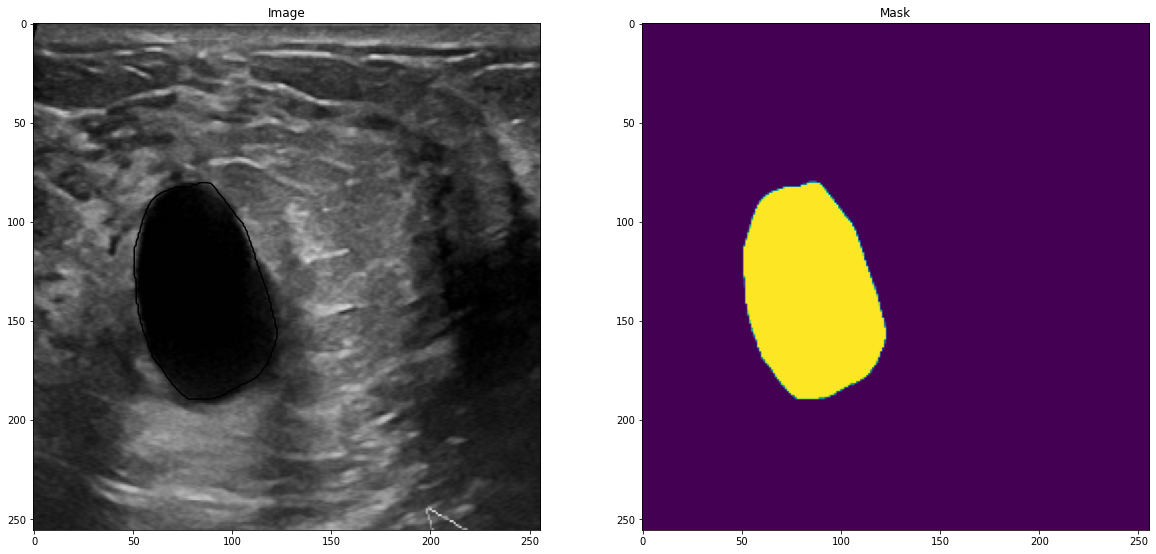

In [10]:
visualize_example(data,index=0)

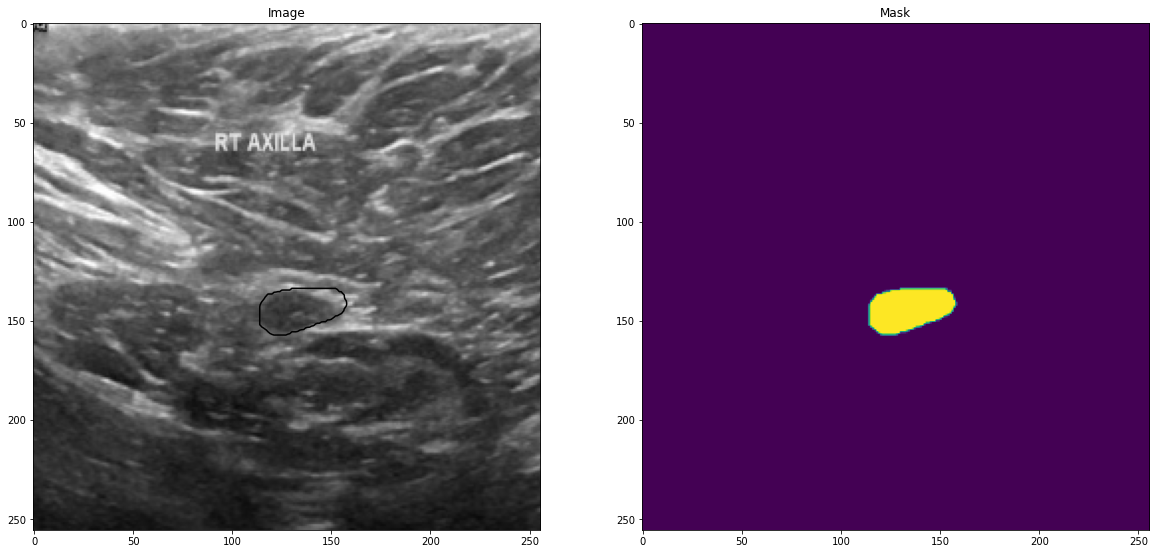

In [11]:
visualize_example(data,index=14)

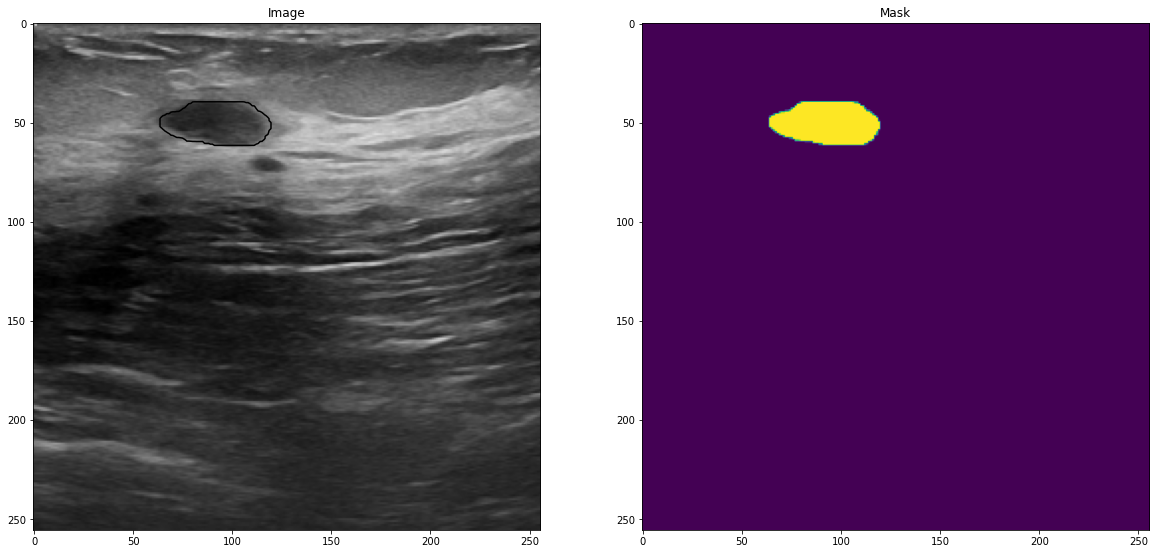

In [12]:
visualize_example(data,index=210)

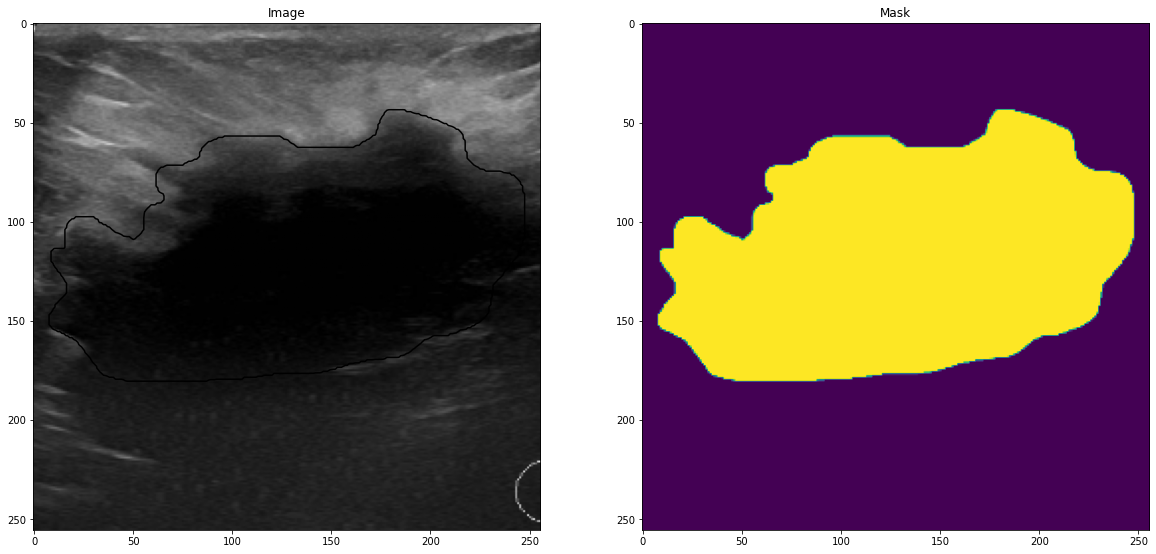

In [13]:
visualize_example(data,index=646)

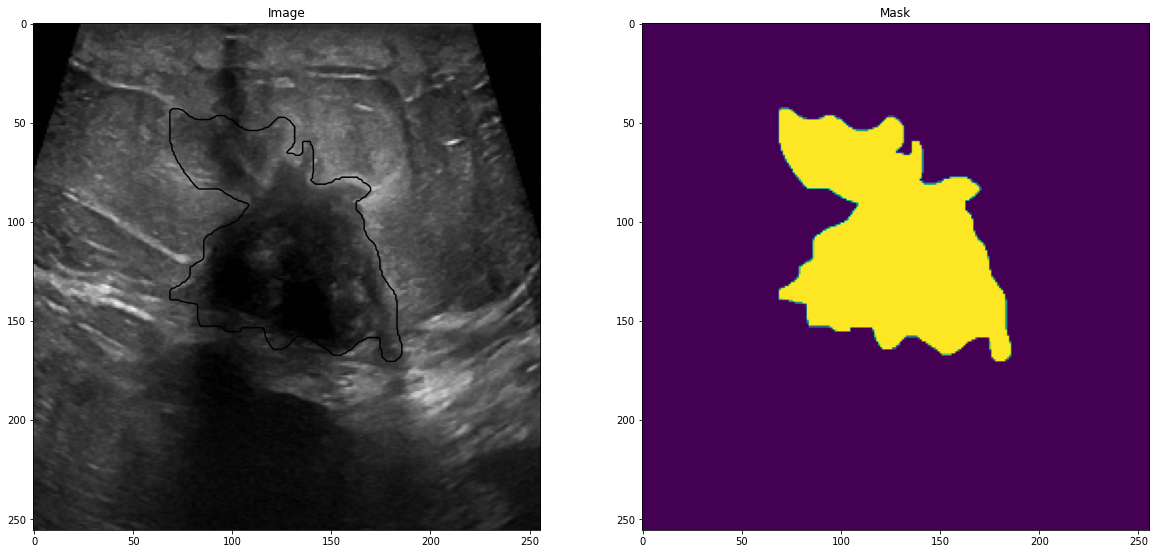

In [14]:
visualize_example(data,index=437)

In [15]:
data['image'] = np.array(data['image'])
data['image'].shape

(647, 256, 256, 3)

new_data_image = data['image'][0:100]
new_data_image.shape

In [16]:
data['mask'] = np.array(data['mask'])
data['mask'] =  np.expand_dims(data['mask'], -1)
data['mask'].shape

(647, 256, 256, 1)

new_data_mask = data['mask'][0:100]
new_data_mask.shape

**Step 6: Train-Test Split**

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(data['image'], data['mask'], test_size=0.2, random_state=42)
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

517 517 130 130


X_train, X_valid, y_train, y_valid = train_test_split(new_data_image, new_data_mask, test_size=0.2, random_state=42)
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

**Step 7: Data Augmentation**: Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.Since the dataset only includes x images, performing data augmentation helps in preventing a neural network from learning irrelevant features. This results in better model performance.

**a)** Here we have defined a function to perform basic augmentation techniques like rotation, flipping, zooming etc.

In [18]:
data_gen_args = dict(
    rotation_range=60,
    zoom_range=[0.6,1.0],
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode="nearest",
)

**b)** Here we are using the Keras deep learning neural network library that provides the capability to fit models using image data augmentation via the ImageDataGenerator class.

In [19]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
seed = 1

In [20]:
image_datagen.fit(X_train, augment=True, seed=seed)

In [21]:
mask_datagen.fit(y_train, augment=True, seed=seed)

**Step 8: Fitting and Creating Train Generator**

In [22]:
image_generator = image_datagen.flow(
    X_train,
    batch_size = 3,
    seed=seed)
mask_generator = mask_datagen.flow(
    y_train,
    batch_size = 3,
    seed=seed)

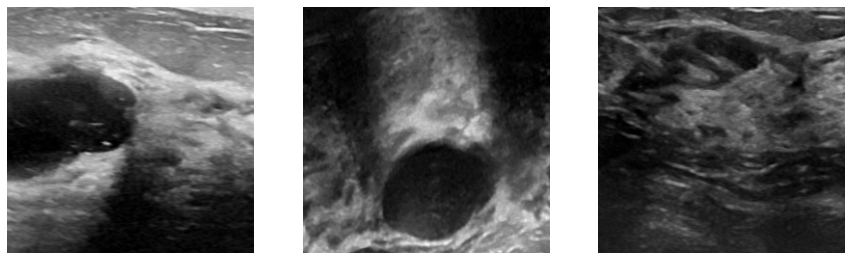

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    image = next(image_generator)[0]
    ax[i].imshow(image)
    ax[i].axis('off')

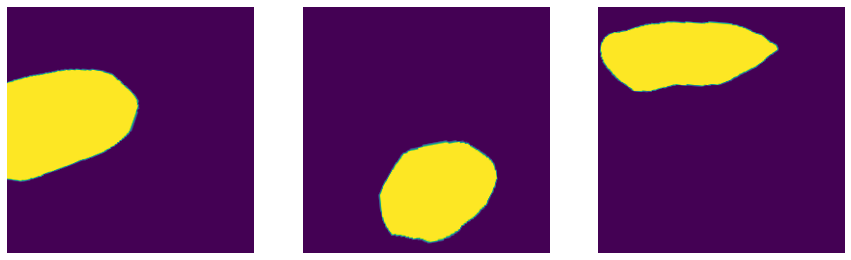

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    image = next(mask_generator)[0]
    ax[i].imshow(image)
    ax[i].axis('off')

In [25]:
train_generator = zip(image_generator, mask_generator)

In [26]:
tf.keras.backend.clear_session()

**Step 9: Defining Loss Functions** In cross entropy loss, the loss is calculated as the average of per-pixel loss, and the per-pixel loss is calculated discretely, without knowing whether its adjacent pixels are boundaries or not.As a result, cross entropy loss only considers loss in a micro sense rather than considering it globally, which is not enough for image level prediction.<br>
![](https://miro.medium.com/max/1050/1*VMiADFOL7x0R9U32qK-C6Q.png)

**Dice loss** originates from *Sørensen–Dice coefficient*, which is a statistic developed in 1940s to gauge the similarity between two samples.Dice loss considers the loss information both locally and globally, which is critical for high accuracy.<br>
![](https://miro.medium.com/max/386/1*EF3VCtk-VbTIKhriaQF0YQ.png)<br>
Here,<br>
**pi,gi** : pairs of corresponding pixel values of prediction and ground truth<br>
*In boundary detection scenario, the values of pi and gi are either 0 or 1, representing whether the pixel is boundary (value of 1) or not (value of 0).*<br>
Therefore, the denominator is the sum of total boundary pixels of both prediction and ground truth, and the numerator is the sum of correctly predicted boundary pixels because the sum increments only when pi and gi match (both of value 1).

In [27]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [28]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [29]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [30]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss

def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

**Step 10: Building U-net Model**

**About U-net:** The UNET was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. <br>
The architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.<br>
![](https://www.researchgate.net/publication/331406702/figure/fig2/AS:731276273262594@1551361258173/Illustration-of-the-U-net-architecture-The-figure-illustrates-the-U-net-architecture.png)

In [31]:
from keras.layers.merge import concatenate, add

In [32]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x


In [33]:
def resnet_block(x, n_filter, strides=1):
    x_init = x
    ## Conv 1
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)
    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)
    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

In [34]:
def get_runet():    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = resnet_block(inputs,32 , strides=1)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = resnet_block(pool1,64 , strides=1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = resnet_block(pool2, 128, strides=1)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = resnet_block(pool3, 256, strides=1)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = resnet_block(up6, 256, strides=1)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = resnet_block(up7, 128, strides=1)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = resnet_block(up8, 64, strides=1)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = resnet_block(up9, 32, strides=1)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
            
    conv9 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv9])
    model.compile(optimizer=Adam(), loss=[loss], metrics=[dice_coef, iou_coef])
    return model


In [35]:
img_rows = 256
img_cols = 256

In [36]:
input_layer= Input((image_height, image_width, 3), name='img')
unet_model = get_runet()
unet_model.summary()

2022-07-20 20:13:19.246463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 20:13:19.349450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 20:13:19.350192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 20:13:19.351328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         activation[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           conv2d[0][0]                     
______________________________________________________________________________________________

input_layer= Input((image_height, image_width, 3), name='img')
unet_model = get_unet(input_layer, n_filters=16, dropout=0.05, batchnorm=True)
unet_model.summary()

**Step 11: Setting up Hyperparameters**

In [37]:
unet_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss= bce_dice_loss,
                  metrics=[dice_loss, dice_coeff, 'accuracy'])

In [38]:
from tensorflow.keras import regularizers, optimizers


lr = 0.00001

sgd = optimizers.SGD(lr, decay=1e-6, momentum=0.9)

unet_model.compile(optimizer=sgd,
                  loss= bce_dice_loss,
                  metrics=[dice_loss, dice_coeff, 'accuracy'])

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [39]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0003, verbose=1),
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True) ]

# Sir changes
callbacks = [ EarlyStopping(patience=25, verbose=1,monitor='val_loss'), 
             ReduceLROnPlateau(factor=0.05 ,patience=10, min_lr=0.0003, verbose=1), 
             ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True) ]

batch_size = 16
epochs = 50

In [40]:
batch_size = 3
epochs = 50

batch_size = 10
epochs = 20

**Step 12: Training the model**

X_train, X_valid, y_train, y_valid

model_history = unet_model.fit(X_train,y_train,  
                    batch_size=batch_size, 
                    steps_per_epoch=int(np.ceil(len(X_train) / float(batch_size))),
                    epochs=epochs, 
                    callbacks=callbacks,
                    validation_data=(X_valid, y_valid),
                    verbose = 1)

history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=40, batch_size=128,callbacks=[es])

In [41]:
model_history = unet_model.fit(train_generator,  
                    batch_size=batch_size, 
                    steps_per_epoch=int(np.ceil(len(X_train) / float(batch_size))),
                    epochs=epochs, 
                    callbacks=callbacks,
                    validation_data=(X_valid, y_valid),
                    verbose = 1)

2022-07-20 20:13:26.695546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-20 20:13:31.700349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


173/173 [==============================] - 28s 91ms/step - loss: 1.1656 - dice_loss: 0.7438 - dice_coeff: 0.2562 - accuracy: 0.8419 - val_loss: 1.1088 - val_dice_loss: 0.8001 - val_dice_coeff: 0.1999 - val_accuracy: 0.9095

Epoch 00001: val_loss improved from inf to 1.10881, saving model to model-checkpoint.h5
Epoch 2/50
173/173 [==============================] - 14s 83ms/step - loss: 1.0512 - dice_loss: 0.6619 - dice_coeff: 0.3381 - accuracy: 0.8521 - val_loss: 0.9543 - val_dice_loss: 0.7166 - val_dice_coeff: 0.2834 - val_accuracy: 0.9181

Epoch 00002: val_loss improved from 1.10881 to 0.95425, saving model to model-checkpoint.h5
Epoch 3/50
173/173 [==============================] - 14s 79ms/step - loss: 1.0215 - dice_loss: 0.6496 - dice_coeff: 0.3504 - accuracy: 0.8598 - val_loss: 1.0047 - val_dice_loss: 0.7211 - val_dice_coeff: 0.2789 - val_accuracy: 0.8977

Epoch 00003: val_loss did not improve from 0.95425
Epoch 4/50
173/173 [==============================] - 14s 83ms/step - loss:

**Step 13: Learning Curve Visualization**

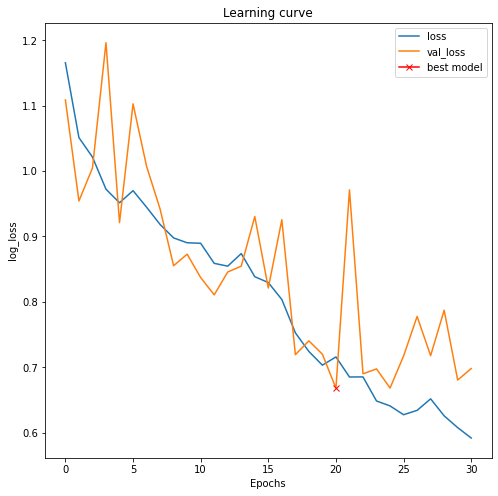

In [42]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Step 14: Evaluating the model on test sets**

In [43]:
unet_model.load_weights('model-checkpoint.h5')
unet_model.evaluate(X_valid, y_valid, verbose=1)

5/5 [==============================] - 3s 206ms/step - loss: 0.6428 - dice_loss: 0.4366 - dice_coeff: 0.5634 - accuracy: 0.9254


[0.6427628993988037,
 0.43663281202316284,
 0.5633671879768372,
 0.9253584742546082]

In [44]:
preds_test = unet_model.predict(X_valid, verbose=1)
preds_test_t = (preds_test > 0.75).astype(np.uint8)

5/5 [==============================] - 1s 94ms/step


**Step 15: Manual Testing**

In [45]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))
#     print("test Image:" ix)
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Mask Predicted binary');
    

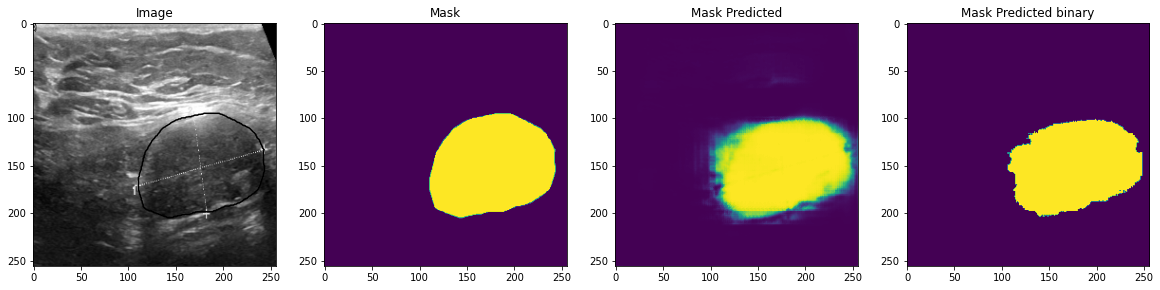

In [46]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

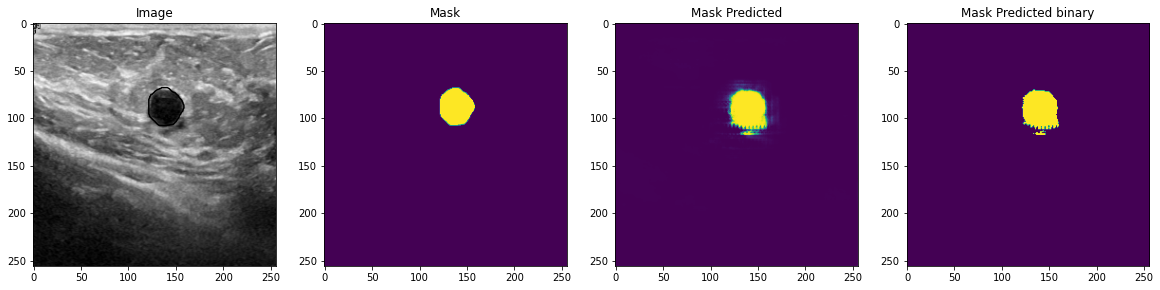

In [47]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

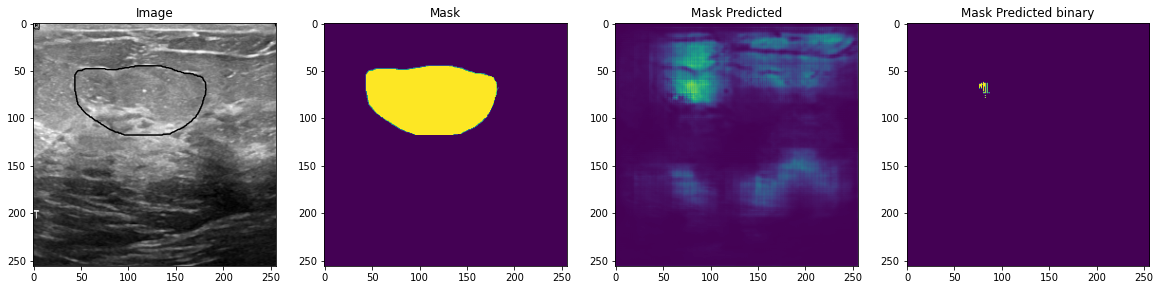

In [48]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

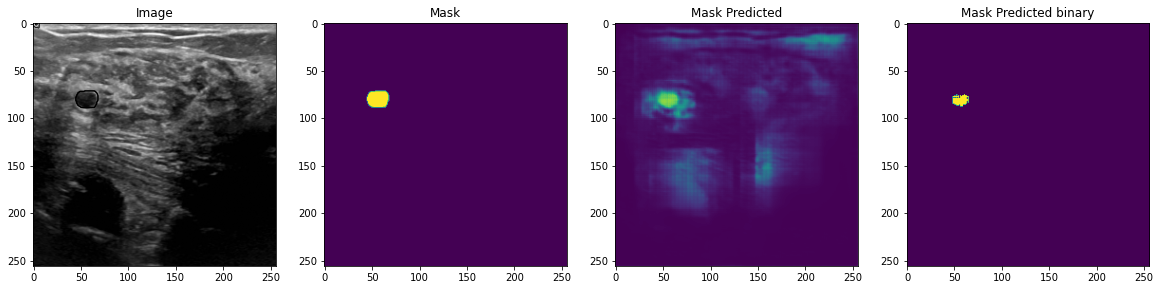

In [49]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

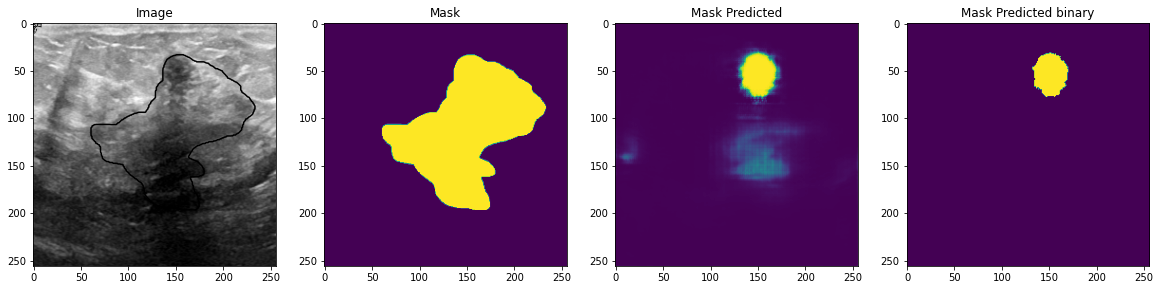

In [50]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

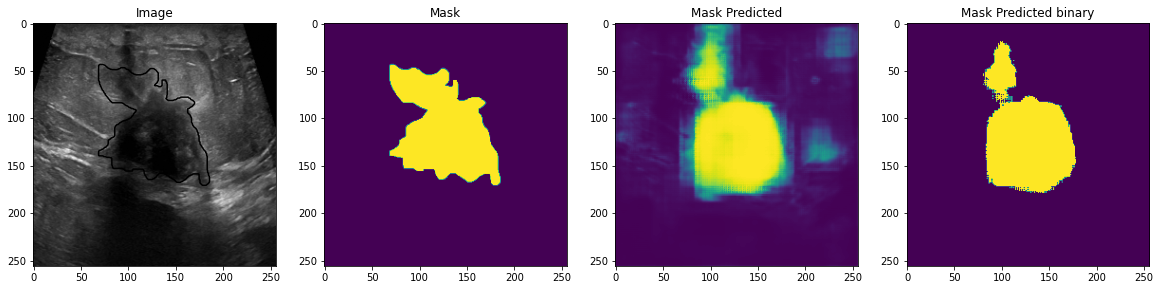

In [51]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

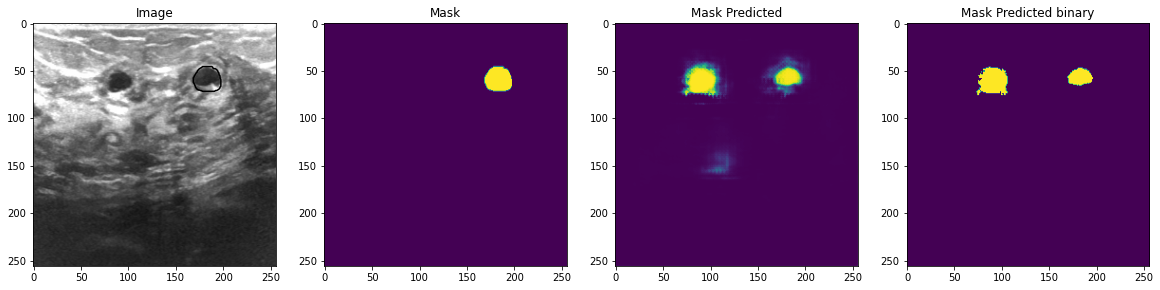

In [52]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

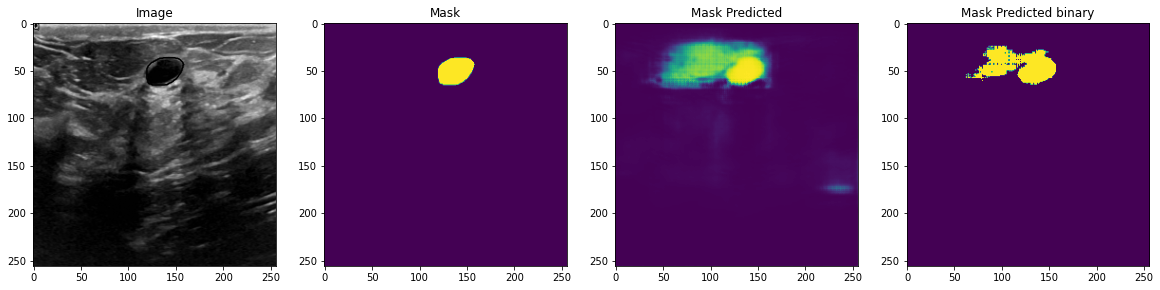

In [53]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

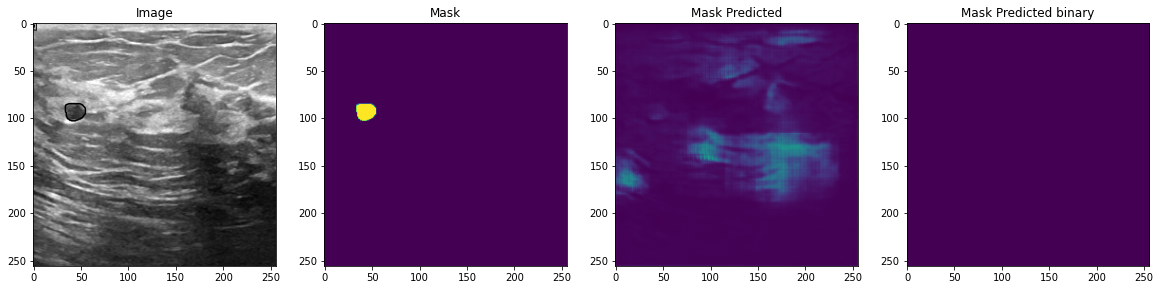

In [54]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

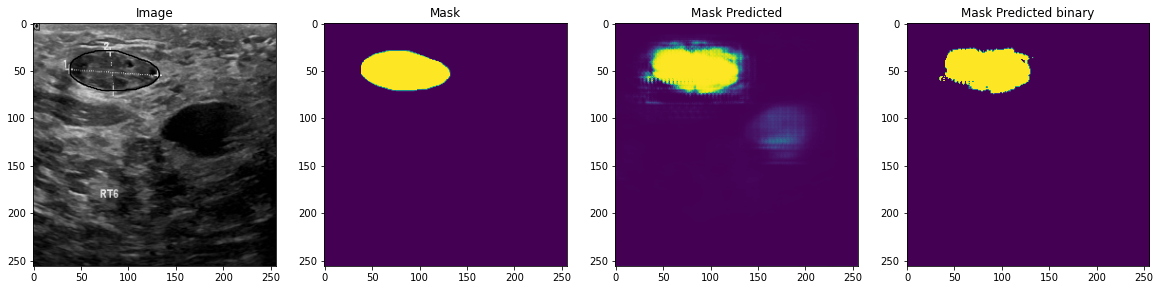

In [55]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)

**Refernces**<br>
* https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b
* https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/#:~:text=Image%20data%20augmentation%20is%20a,of%20images%20in%20the%20dataset.
* https://www.section.io/engineering-education/image-preprocessing-in-python/#:~:text=In%20this%20tutorial%2C%20we%20shall,used%20to%20preprocess%20image%20data.
* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
